In [57]:
import pandas as pd
import numpy as np
from IPython.display import display


In [58]:
# Cargar dataset
df = pd.read_csv('./netflix_titles.csv', encoding='utf-8')


# 1. Limpieza y normalizacion de datos

## 1.1. Inspección Basica

In [59]:
# Analisis general de los datos (Observar las columnas, su cantidad y su tipo de datos )
print(f'Datos originales: {df.shape}')
print(df.info())

Datos originales: (8807, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB
None


In [60]:
# Observar las primeras filas 
from IPython.display import display, HTML

display(HTML(df.head().to_html(index=False)))


show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmmaker Kirsten Johnson stages his death in inventive and comical ways to help them both face the inevitable."
s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thabang Molaba, Dillon Windvogel, Natasha Thahane, Arno Greeff, Xolile Tshabalala, Getmore Sithole, Cindy Mahlangu, Ryle De Morny, Greteli Fincham, Sello Maake Ka-Ncube, Odwa Gwanya, Mekaila Mathys, Sandi Schultz, Duane Williams, Shamilla Miller, Patrick Mofokeng",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town teen sets out to prove whether a private-school swimming star is her sister who was abducted at birth."
s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabiha Akkari, Sofia Lesaffre, Salim Kechiouche, Noureddine Farihi, Geert Van Rampelberg, Bakary Diombera",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Action & Adventure","To protect his family from a powerful drug lord, skilled thief Mehdi and his expert team of robbers are pulled into a violent and deadly turf war."
s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down among the incarcerated women at the Orleans Justice Center in New Orleans on this gritty reality series."
s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam Khan, Ahsaas Channa, Revathi Pillai, Urvi Singh, Arun Kumar",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV Comedies","In a city of coaching centers known to train India’s finest collegiate minds, an earnest but unexceptional student and his friends navigate campus life."


## 1.2. Eliminar duplicados

In [61]:

df = df.drop_duplicates(subset='show_id')
print(f'Datos tras eliminar duplicados: {df.shape}')


Datos tras eliminar duplicados: (8807, 12)


## 1.3. Manejar valores faltantes

In [62]:

# Calcular % de nulos por columna
null_fraction = df.isnull().mean().sort_values(ascending=False)

# Crear DataFrame con porcentaje
null_stats = pd.DataFrame({
    'column': null_fraction.index,
    'null_fraction': null_fraction.values,
    'null_percentage': (null_fraction.values * 100).round(2)
})

# Formatear y mostrar con estilo
display(
    null_stats.style
    .hide_index()
    .format({
        'null_fraction': "{:.4f}",
        'null_percentage': "{:.2f} %"
    })
    .set_caption("Porcentaje de valores nulos por columna")
    .set_table_styles([
        {'selector': 'caption', 'props': 'caption-side: top; font-weight: bold; font-size: 14px;'}
    ])
)


C:\Users\Jhampier\AppData\Local\Temp\ipykernel_38132\777972063.py:14: FutureWarning: this method is deprecated in favour of `Styler.hide(axis="index")`
  .hide_index()


column,null_fraction,null_percentage
director,0.2991,29.91 %
country,0.0944,9.44 %
cast,0.0937,9.37 %
date_added,0.0011,0.11 %
rating,0.0005,0.05 %
duration,0.0003,0.03 %
show_id,0.0000,0.00 %
type,0.0000,0.00 %
title,0.0000,0.00 %
release_year,0.0000,0.00 %


#### Llenar los valores vacios para normalizar los datos

In [63]:
# director: llenar con "Unknown"
df['director'] = df['director'].fillna('Unknown')

# country: llenar con "Unknown"
df['country'] = df['country'].fillna('Unknown')

# cast: llenar con "Unknown"
df['cast'] = df['cast'].fillna('Unknown')

# date_added: llenar nulos con fecha 25 diciembre 1999
df['date_added'] = df['date_added'].fillna( 'December 25, 1999')

# rating: llenar con "Not Rated"
df['rating'] = df['rating'].fillna('Not Rated')

# duration: llenar nulos con "0 min"
df['duration'] = df['duration'].fillna('0 min')


## 1.4. Normalizar formato de fecha: 'date_added'

In [64]:
# Convertir a datetime y extraer año, mes para análisis
def parse_date(date):
    try:
        return pd.to_datetime(date)
    except:
        return pd.NaT

df['date_added'] = df['date_added'].apply(parse_date)
df['year_added'] = df['date_added'].dt.year
df['month_added'] = df['date_added'].dt.month



In [65]:
# Mostrar nuevo DataFrame
from IPython.display import display, HTML

display(HTML(df.head().to_html(index=False)))

show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,year_added,month_added
s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,Unknown,United States,2021-09-25,2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmmaker Kirsten Johnson stages his death in inventive and comical ways to help them both face the inevitable.",2021,9
s2,TV Show,Blood & Water,Unknown,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thabang Molaba, Dillon Windvogel, Natasha Thahane, Arno Greeff, Xolile Tshabalala, Getmore Sithole, Cindy Mahlangu, Ryle De Morny, Greteli Fincham, Sello Maake Ka-Ncube, Odwa Gwanya, Mekaila Mathys, Sandi Schultz, Duane Williams, Shamilla Miller, Patrick Mofokeng",South Africa,2021-09-24,2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town teen sets out to prove whether a private-school swimming star is her sister who was abducted at birth.",2021,9
s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabiha Akkari, Sofia Lesaffre, Salim Kechiouche, Noureddine Farihi, Geert Van Rampelberg, Bakary Diombera",Unknown,2021-09-24,2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Action & Adventure","To protect his family from a powerful drug lord, skilled thief Mehdi and his expert team of robbers are pulled into a violent and deadly turf war.",2021,9
s4,TV Show,Jailbirds New Orleans,Unknown,Unknown,Unknown,2021-09-24,2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down among the incarcerated women at the Orleans Justice Center in New Orleans on this gritty reality series.",2021,9
s5,TV Show,Kota Factory,Unknown,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam Khan, Ahsaas Channa, Revathi Pillai, Urvi Singh, Arun Kumar",India,2021-09-24,2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV Comedies","In a city of coaching centers known to train India’s finest collegiate minds, an earnest but unexceptional student and his friends navigate campus life.",2021,9


## 1.5. Normalizar columnas con valores múltiples (ej: 'country', 'listed_in', 'cast')

In [66]:
# Separar campos múltiples en listas para futuras tablas relacionales

df['country_list'] = df['country'].apply(lambda x: [c.strip() for c in x.split(',')] if x != 'Unknown' else [])
df['listed_in_list'] = df['listed_in'].apply(lambda x: [c.strip() for c in x.split(',')] if pd.notnull(x) else [])
df['cast_list'] = df['cast'].apply(lambda x: [c.strip() for c in x.split(',')] if x != 'Unknown' else [])



## 1.6. Normalizar columna 'duration'

In [67]:
# Extraer duración en minutos para películas, y temporadas para shows

def parse_duration(row):
    if pd.isnull(row):
        return np.nan
    if 'min' in row:
        return int(row.replace('min', '').strip())
    elif 'Season' in row or 'Seasons' in row:
        return int(row.split(' ')[0].strip())
    else:
        return np.nan

df['duration_int'] = df['duration'].apply(parse_duration)



## 1.7. Normalizar texto: pasar a minúsculas y quitar espacios extras en columnas textuales


In [68]:
def clean_text(text):
    if pd.isnull(text):
        return ''
    return ' '.join(text.strip().lower().split())

for col in ['type', 'title', 'director', 'rating', 'description']:
    df[col] = df[col].apply(clean_text)



In [69]:
# Mostrar nuevo DataFrame
from IPython.display import display, HTML

display(HTML(df.head().to_html(index=False)))

show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,year_added,month_added,country_list,listed_in_list,cast_list,duration_int
s1,movie,dick johnson is dead,kirsten johnson,Unknown,United States,2021-09-25,2020,pg-13,90 min,Documentaries,"as her father nears the end of his life, filmmaker kirsten johnson stages his death in inventive and comical ways to help them both face the inevitable.",2021,9,[United States],[Documentaries],[],90
s2,tv show,blood & water,unknown,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thabang Molaba, Dillon Windvogel, Natasha Thahane, Arno Greeff, Xolile Tshabalala, Getmore Sithole, Cindy Mahlangu, Ryle De Morny, Greteli Fincham, Sello Maake Ka-Ncube, Odwa Gwanya, Mekaila Mathys, Sandi Schultz, Duane Williams, Shamilla Miller, Patrick Mofokeng",South Africa,2021-09-24,2021,tv-ma,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","after crossing paths at a party, a cape town teen sets out to prove whether a private-school swimming star is her sister who was abducted at birth.",2021,9,[South Africa],"[International TV Shows, TV Dramas, TV Mysteries]","[Ama Qamata, Khosi Ngema, Gail Mabalane, Thabang Molaba, Dillon Windvogel, Natasha Thahane, Arno Greeff, Xolile Tshabalala, Getmore Sithole, Cindy Mahlangu, Ryle De Morny, Greteli Fincham, Sello Maake Ka-Ncube, Odwa Gwanya, Mekaila Mathys, Sandi Schultz, Duane Williams, Shamilla Miller, Patrick Mofokeng]",2
s3,tv show,ganglands,julien leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabiha Akkari, Sofia Lesaffre, Salim Kechiouche, Noureddine Farihi, Geert Van Rampelberg, Bakary Diombera",Unknown,2021-09-24,2021,tv-ma,1 Season,"Crime TV Shows, International TV Shows, TV Action & Adventure","to protect his family from a powerful drug lord, skilled thief mehdi and his expert team of robbers are pulled into a violent and deadly turf war.",2021,9,[],"[Crime TV Shows, International TV Shows, TV Action & Adventure]","[Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabiha Akkari, Sofia Lesaffre, Salim Kechiouche, Noureddine Farihi, Geert Van Rampelberg, Bakary Diombera]",1
s4,tv show,jailbirds new orleans,unknown,Unknown,Unknown,2021-09-24,2021,tv-ma,1 Season,"Docuseries, Reality TV","feuds, flirtations and toilet talk go down among the incarcerated women at the orleans justice center in new orleans on this gritty reality series.",2021,9,[],"[Docuseries, Reality TV]",[],1
s5,tv show,kota factory,unknown,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam Khan, Ahsaas Channa, Revathi Pillai, Urvi Singh, Arun Kumar",India,2021-09-24,2021,tv-ma,2 Seasons,"International TV Shows, Romantic TV Shows, TV Comedies","in a city of coaching centers known to train india’s finest collegiate minds, an earnest but unexceptional student and his friends navigate campus life.",2021,9,[India],"[International TV Shows, Romantic TV Shows, TV Comedies]","[Mayur More, Jitendra Kumar, Ranjan Raj, Alam Khan, Ahsaas Channa, Revathi Pillai, Urvi Singh, Arun Kumar]",2


## 1.8. Revisar tipos de datos para base de datos

In [70]:
print(df.dtypes)

# El dataset ahora está limpio y con datos normalizados para insertar en la base de datos normalizada.

# Exportar CSV limpio
df.to_csv('netflix_cleaned.csv', index=False)

show_id                   object
type                      object
title                     object
director                  object
cast                      object
country                   object
date_added        datetime64[ns]
release_year               int64
rating                    object
duration                  object
listed_in                 object
description               object
year_added                 int64
month_added                int64
country_list              object
listed_in_list            object
cast_list                 object
duration_int               int64
dtype: object


# 2. Creacion de tablas normalizadas para SQL Server

## 2.1. Se crean 8 tablas para manejar los datos normalizados

In [ ]:
import pandas as pd
import os
import ast # For safely evaluating string representations of lists

def parse_list_string(data):
    """
    Safely parses a string representation of a list.
    Handles NaN, None, or already list-like data.
    """
    if isinstance(data, (list, tuple)):
        return data
    if pd.isna(data) or data is None or data == "Unknown": # Treat "Unknown" in list columns as empty
        return []
    try:
        # Ensure the string looks like a list before parsing
        if isinstance(data, str) and data.startswith('[') and data.endswith(']'):
            return ast.literal_eval(data)
        elif isinstance(data, str): # Handle single items not in list format, wrap them in a list
            return [data.strip()] if data.strip() else []
        return []
    except (ValueError, SyntaxError):
        # If parsing fails, return an empty list or handle as appropriate
        # This might happen for malformed strings.
        # For single, non-list strings, we can split by a delimiter if known,
        # or treat as a single-element list. Here, we assume if not a list string, it's a single item.
        if isinstance(data, str): # If it's a string but not a list format
             # If your single items might be comma-separated in the string, use:
             # return [s.strip() for s in data.split(',') if s.strip()]
             return [data.strip()] if data.strip() else [] # Treats the whole string as one item
        return []

def main_normalization(csv_file_path='netflix_cleaned.csv', output_folder='./normalized_tables_v2/'):
    """
    Reads the raw CSV, normalizes data into 8 tables, and saves them as CSVs.
    """
    # --- 0. Cargar y Preprocesar el DataFrame Principal ---
    try:
        df = pd.read_csv(csv_file_path)
    except FileNotFoundError:
        print(f"Error: El archivo '{csv_file_path}' no fue encontrado.")
        # Se crea un data frame de ejemplo por si no se encuentra el archivo
        print("Creando un DataFrame de ejemplo para demostración...")
        data_dict = {
            'show_id': [f's{i}' for i in range(1, 6)],
            'type': ['Movie', 'TV Show', 'Movie', 'TV Show', 'Movie'],
            'title': [f'Title {i}' for i in range(1, 6)],
            'director': ['Director A', 'Director B', 'Director A', None, 'Director C'],
            'cast_list': ["['Actor X', 'Actor Y']", "['Actor Z']", "['Actor X', 'Actor W']", "[]", "['Actor Y']"],
            'country_list': ["['USA']", "['Canada', 'USA']", "['UK']", "['India']", "['Germany']"],
            'date_added': ['25-Sep-21', '24-Sep-21', '23-Sep-21', '22-Sep-21', '21-Sep-21'], 
            'release_year': [2021, 2021, 2020, 2020, 2019],
            'rating': ['PG-13', 'TV-MA', 'R', 'TV-14', 'G'],
            'duration': ['90 min', '2 Seasons', '120 min', '1 Season', '100 min'],
            'listed_in_list': ["['Dramas', 'Independent Movies']", "['International TV Shows', 'TV Dramas']", "['Action & Adventure']", "['Docuseries']", "['Comedies']"],
            'description': [f'Description for s{i}' for i in range(1, 6)],
            'year_added': [2021, 2021, 2020, 2020, 2019],
            'month_added': [9, 9, 9, 9, 9] 
        }
        df = pd.DataFrame(data_dict)
        print("DataFrame de ejemplo creado.")
        # return # Opcional

    print("DataFrame original cargado.")
    df.rename(columns={'month_adde': 'month_added'}, inplace=True, errors='ignore') # Ensure correct column name

    # Parsear columnas que son strings de listas a listas reales
    list_columns = ['cast_list', 'country_list', 'listed_in_list']
    for col in list_columns:
        if col in df.columns:
            df[col] = df[col].apply(parse_list_string)
        else:
            print(f"Advertencia: La columna esperada '{col}' no se encontró en el CSV. Se creará vacía si es necesario.")
            df[col] = pd.Series([[] for _ in range(len(df))])


    # Convertir 'date_added' a datetime, manejar varios formatos posibles y errores
    try:
        df['date_added'] = pd.to_datetime(df['date_added'], errors='coerce')
    except Exception as e:
        print(f"Error al convertir 'date_added': {e}. Se intentarán formatos específicos.")
        try:
            df['date_added'] = pd.to_datetime(df['date_added'], format='%d-%b-%y', errors='coerce')
        except ValueError:
            try:
                df['date_added'] = pd.to_datetime(df['date_added'], format='%d/%m/%Y', errors='coerce')
            except ValueError:
                 print("No se pudo parsear 'date_added' con los formatos comunes. Se dejará como NaT donde falle.")
                 df['date_added'] = pd.NaT # Set to Not a Time if all parsing fails


    # --- 1. Tabla directors ---
    # Usar dropna() para excluir directores NaN/None de la tabla 'directors'
    unique_directors = df['director'].dropna().unique()
    directors_df = pd.DataFrame(unique_directors, columns=['director_name'])
    directors_df.insert(0, 'director_id', range(1, len(directors_df) + 1))
    print("Tabla 'directors' creada.")

    # --- 2. Tabla cast_members ---
    all_cast_members = [member for sublist in df['cast_list'] for member in sublist if member and member.lower() != 'unknown']
    unique_cast_members = sorted(list(set(all_cast_members)))
    cast_members_df = pd.DataFrame(unique_cast_members, columns=['cast_member_name'])
    cast_members_df.insert(0, 'cast_member_id', range(1, len(cast_members_df) + 1))
    print("Tabla 'cast_members' creada.")

    # --- 3. Tabla countries ---
    all_countries = [country for sublist in df['country_list'] for country in sublist if country and country.lower() != 'unknown']
    unique_countries = sorted(list(set(all_countries)))
    countries_df = pd.DataFrame(unique_countries, columns=['country_name'])
    countries_df.insert(0, 'country_id', range(1, len(countries_df) + 1))
    print("Tabla 'countries' creada.")

    # --- 4. Tabla genres ---
    all_genres = [genre for sublist in df['listed_in_list'] for genre in sublist if genre and genre.lower() != 'unknown']
    unique_genres = sorted(list(set(all_genres)))
    genres_df = pd.DataFrame(unique_genres, columns=['genre_name'])
    genres_df.insert(0, 'genre_id', range(1, len(genres_df) + 1))
    print("Tabla 'genres' creada.")

    # --- 5. Tabla shows ---
    # Merge para obtener director_id
    shows_df = df.merge(directors_df, left_on='director', right_on='director_name', how='left')
    
    # Seleccionar y renombrar columnas para la tabla 'shows'
    shows_df = shows_df[[
        'show_id', 'type', 'title', 'director_id', 'date_added', 
        'release_year', 'rating', 'duration', 'description', 
        'year_added', 'month_added' 
    ]]
    # Asegurar que director_id es Int64 para permitir <NA> (equivalente a NULL de SQL)
    shows_df['director_id'] = shows_df['director_id'].astype(pd.Int64Dtype())
    # Convertir release_year, year_added, month_added a Int64 si no lo son ya
    for col in ['release_year', 'year_added', 'month_added']:
        if col in shows_df.columns:
            shows_df[col] = pd.to_numeric(shows_df[col], errors='coerce').astype(pd.Int64Dtype())

    print("Tabla 'shows' creada.")

    # --- Tablas de Unión (Muchos a Muchos) ---

    # --- 6. Tabla show_cast_members ---
    show_cast_members_list = []
    # Crear un mapeo de nombre de actor a ID para eficiencia
    cast_member_to_id = pd.Series(cast_members_df.cast_member_id.values, index=cast_members_df.cast_member_name).to_dict()
    for index, row in df.iterrows():
        show_id = row['show_id']
        for member_name in row['cast_list']:
            if member_name and member_name.lower() != 'unknown':
                cast_member_id = cast_member_to_id.get(member_name)
                if cast_member_id: # Solo añadir si el actor está en nuestra tabla de cast_members
                    show_cast_members_list.append({'show_id': show_id, 'cast_member_id': cast_member_id})
    show_cast_members_df = pd.DataFrame(show_cast_members_list).drop_duplicates()
    print("Tabla 'show_cast_members' creada.")

    # --- 7. Tabla show_countries ---
    show_countries_list = []
    country_to_id = pd.Series(countries_df.country_id.values, index=countries_df.country_name).to_dict()
    for index, row in df.iterrows():
        show_id = row['show_id']
        for country_name in row['country_list']:
            if country_name and country_name.lower() != 'unknown':
                country_id = country_to_id.get(country_name)
                if country_id:
                    show_countries_list.append({'show_id': show_id, 'country_id': country_id})
    show_countries_df = pd.DataFrame(show_countries_list).drop_duplicates()
    print("Tabla 'show_countries' creada.")

    # --- 8. Tabla show_genres ---
    show_genres_list = []
    genre_to_id = pd.Series(genres_df.genre_id.values, index=genres_df.genre_name).to_dict()
    for index, row in df.iterrows():
        show_id = row['show_id']
        for genre_name in row['listed_in_list']:
            if genre_name and genre_name.lower() != 'unknown':
                genre_id = genre_to_id.get(genre_name)
                if genre_id:
                    show_genres_list.append({'show_id': show_id, 'genre_id': genre_id})
    show_genres_df = pd.DataFrame(show_genres_list).drop_duplicates()
    print("Tabla 'show_genres' creada.")

    # --- Guardar DataFrames a CSV ---
    os.makedirs(output_folder, exist_ok=True)

    shows_df.to_csv(os.path.join(output_folder, 'shows.csv'), index=False, encoding='utf-8')
    directors_df.to_csv(os.path.join(output_folder, 'directors.csv'), index=False, encoding='utf-8')
    cast_members_df.to_csv(os.path.join(output_folder, 'cast_members.csv'), index=False, encoding='utf-8')
    countries_df.to_csv(os.path.join(output_folder, 'countries.csv'), index=False, encoding='utf-8')
    genres_df.to_csv(os.path.join(output_folder, 'genres.csv'), index=False, encoding='utf-8')
    show_cast_members_df.to_csv(os.path.join(output_folder, 'show_cast_members.csv'), index=False, encoding='utf-8')
    show_countries_df.to_csv(os.path.join(output_folder, 'show_countries.csv'), index=False, encoding='utf-8')
    show_genres_df.to_csv(os.path.join(output_folder, 'show_genres.csv'), index=False, encoding='utf-8')

    print(f"\nArchivos CSV normalizados guardados en la carpeta: {output_folder}")
    print_shapes(shows_df, directors_df, cast_members_df, countries_df, genres_df, 
                 show_cast_members_df, show_countries_df, show_genres_df)


def print_shapes(shows, directors, cast_members, countries, genres, show_cast, show_country, show_genre):
    print("\nForma de los DataFrames (filas, columnas):")
    print(f"Shows: {shows.shape}")
    print(f"Directors: {directors.shape}")
    print(f"Cast Members: {cast_members.shape}")
    print(f"Countries: {countries.shape}")
    print(f"Genres: {genres.shape}")
    print(f"Show-Cast Members: {show_cast.shape}")
    print(f"Show-Countries: {show_country.shape}")
    print(f"Show-Genres: {show_genre.shape}")

if __name__ == '__main__':
    # Llama a la función principal. 
    # o proporciona la ruta completa al archivo.
    main_normalization(csv_file_path='netflix_cleaned.csv')


DataFrame original cargado.
Tabla 'directors' creada.
Tabla 'cast_members' creada.
Tabla 'countries' creada.
Tabla 'genres' creada.
Tabla 'shows' creada.
Tabla 'show_cast_members' creada.
Tabla 'show_countries' creada.
Tabla 'show_genres' creada.

Archivos CSV normalizados guardados en la carpeta: ./normalized_tables_v2/

Forma de los DataFrames (filas, columnas):
Shows: (8807, 11)
Directors: (4527, 2)
Cast Members: (36439, 2)
Countries: (122, 2)
Genres: (42, 2)
Show-Cast Members: (64124, 2)
Show-Countries: (10012, 2)
Show-Genres: (19323, 2)


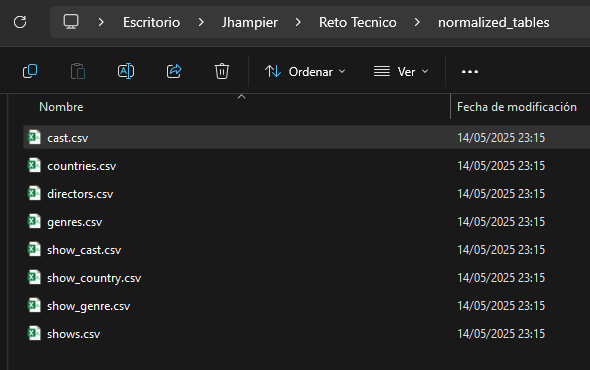
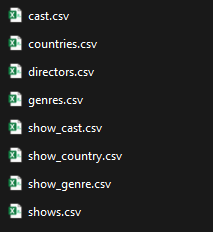

## 2.2. Script para crear BD

In [ ]:
-- Tabla directors
CREATE TABLE directors (
    director_id SERIAL PRIMARY KEY,
    director_name VARCHAR(255) NOT NULL UNIQUE
);

-- Tabla cast_members (reemplaza la anterior 'casts')
CREATE TABLE cast_members (
    cast_member_id SERIAL PRIMARY KEY,
    cast_member_name VARCHAR(255) NOT NULL UNIQUE
);

-- Tabla countries
CREATE TABLE countries (
    country_id SERIAL PRIMARY KEY,
    country_name VARCHAR(255) NOT NULL UNIQUE
);

-- Tabla genres
CREATE TABLE genres (
    genre_id SERIAL PRIMARY KEY,
    genre_name VARCHAR(255) NOT NULL UNIQUE
);

-- Tabla shows
CREATE TABLE shows (
    show_id VARCHAR(50) PRIMARY KEY,
    type VARCHAR(50),
    title VARCHAR(255),
    director_id INT, -- Permite NULL si un show no tiene director
    date_added DATE,
    release_year INT,
    rating VARCHAR(50),
    duration VARCHAR(50),
    description TEXT,
    year_added INT,
    month_added INT,
    CONSTRAINT fk_director FOREIGN KEY (director_id) REFERENCES directors(director_id) ON DELETE SET NULL -- O ON DELETE RESTRICT
);

-- Tabla show_cast_members (relación muchos a muchos)
CREATE TABLE show_cast_members (
    show_id VARCHAR(50),
    cast_member_id INT,
    PRIMARY KEY (show_id, cast_member_id),
    CONSTRAINT fk_show FOREIGN KEY (show_id) REFERENCES shows(show_id) ON DELETE CASCADE,
    CONSTRAINT fk_cast_member FOREIGN KEY (cast_member_id) REFERENCES cast_members(cast_member_id) ON DELETE CASCADE
);

-- Tabla show_countries (relación muchos a muchos)
CREATE TABLE show_countries (
    show_id VARCHAR(50),
    country_id INT,
    PRIMARY KEY (show_id, country_id),
    CONSTRAINT fk_show FOREIGN KEY (show_id) REFERENCES shows(show_id) ON DELETE CASCADE,
    CONSTRAINT fk_country FOREIGN KEY (country_id) REFERENCES countries(country_id) ON DELETE CASCADE
);

-- Tabla show_genres (relación muchos a muchos)
CREATE TABLE show_genres (
    show_id VARCHAR(50),
    genre_id INT,
    PRIMARY KEY (show_id, genre_id),
    CONSTRAINT fk_show FOREIGN KEY (show_id) REFERENCES shows(show_id) ON DELETE CASCADE,
    CONSTRAINT fk_genre FOREIGN KEY (genre_id) REFERENCES genres(genre_id) ON DELETE CASCADE
);

## 2.3. Diagrama Fisico de Datos

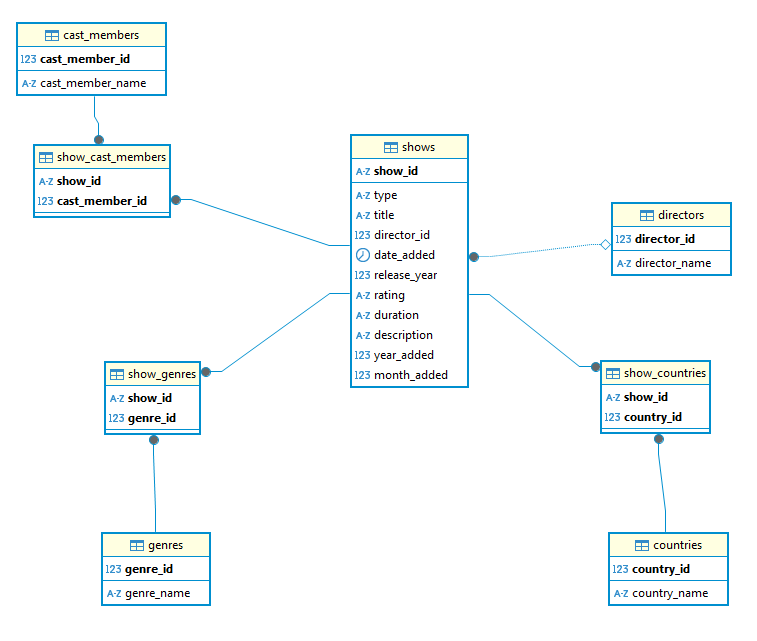

## 2.4. Script para subir los datos a las tablas

In [ ]:
# Se instala las librerias necesarias
pip install psycopg2-binary pandas


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import psycopg2
import os

# --- PARÁMETROS DE CONEXIÓN A POSTGRESQL ---
CONN_PARAMS = {
    'dbname': 'defaultdb',    
    'user': 'avnadmin',         
    'password': 'AVNS_-K9wqvn-Il-VmM7LHpJ',   
    'host': 'pg-aeca7bc-jhampierquispe9-78a6.g.aivencloud.com',            
    'port': '14788'                 
}

# Directorio donde se encuentran los archivos CSV generados por pandas_normalization_v2.py
CSV_DIR = './normalized_tables_v2/'

def load_data_from_csv(conn, table_name, csv_filename, columns_tuple):
    """
    Carga datos desde un archivo CSV a la tabla especificada usando el comando COPY.

    """
    csv_file_path = os.path.join(CSV_DIR, csv_filename)
    cursor = None  # Inicializar cursor a None
    sql_command = "" # Para depuración en caso de error

    try:
        # Verificar si el archivo CSV existe
        if not os.path.exists(csv_file_path):
            print(f"Error: Archivo CSV no encontrado en {csv_file_path}")
            raise FileNotFoundError(f"Archivo CSV no encontrado: {csv_file_path}")

        cursor = conn.cursor()
        
        # Construir la parte de columnas para el comando SQL: (col1, col2, ...)
        
        sql_columns = ", ".join(columns_tuple)
        
        # Comando SQL COPY
        
        sql_command = f"COPY {table_name} ({sql_columns}) FROM STDIN WITH CSV HEADER DELIMITER ',' NULL ''"
        # El NULL '' le dice a COPY que trate las cadenas vacías como NULL.
        
        print(f"Cargando datos desde '{csv_filename}' a la tabla '{table_name}'...")
        # print(f"Ejecutando SQL: {sql_command}") # Descomentar para depuración
        
        with open(csv_file_path, 'r', encoding='utf-8') as f:
            cursor.copy_expert(sql_command, f)
        
        conn.commit() # Confirmar la transacción para esta tabla
        print(f"Datos cargados exitosamente en la tabla '{table_name}'.")

    except FileNotFoundError as fnf_err:
        print(str(fnf_err))
        # Si el archivo no se encuentra, no se puede continuar con esta tabla.
        
        raise
    except psycopg2.Error as db_err:
        if conn:
            conn.rollback() # Revertir cambios si hubo un error con esta tabla
        print(f"Error de base de datos al cargar datos en '{table_name}' desde '{csv_filename}':")
        print(f"Error de Psycopg2: {db_err}")
        print(f"SQL que causó el error (aproximado): {sql_command}")
        raise # Relanzar para ser capturado por el try-except principal
    except Exception as e:
        if conn:
            conn.rollback()
        print(f"Error inesperado al cargar datos en '{table_name}' desde '{csv_filename}': {e}")
        if sql_command:
             print(f"SQL (si está disponible): {sql_command}")
        raise # Relanzar
    finally:
        if cursor:
            cursor.close()

def main():
    """
    Función principal para conectar a la base de datos y cargar todas las tablas.
    """
    conn = None  # Inicializar conn a None para el bloque finally
    
    # Lista de tablas a cargar, en orden de dependencias
    # (tabla_db, archivo_csv, (columnas_csv_y_db))
    tables_to_load = [
        ('directors', 'directors.csv', ('director_id', 'director_name')),
        ('cast_members', 'cast_members.csv', ('cast_member_id', 'cast_member_name')),
        ('countries', 'countries.csv', ('country_id', 'country_name')),
        ('genres', 'genres.csv', ('genre_id', 'genre_name')),
        ('shows', 'shows.csv', (
            'show_id', 'type', 'title', 'director_id', 'date_added', 
            'release_year', 'rating', 'duration', 'description', 
            'year_added', 'month_added'
        )),
        ('show_cast_members', 'show_cast_members.csv', ('show_id', 'cast_member_id')),
        ('show_countries', 'show_countries.csv', ('show_id', 'country_id')),
        ('show_genres', 'show_genres.csv', ('show_id', 'genre_id'))
    ]

    try:
        # Establecer conexión con la base de datos
        print("Conectando a la base de datos PostgreSQL...")
        conn = psycopg2.connect(**CONN_PARAMS)
        print("Conexión exitosa.")

        # Cargar datos para cada tabla
        for db_table, csv_file, columns in tables_to_load:
            load_data_from_csv(conn, db_table, csv_file, columns)

        print("\nTodos los procesos de carga de datos han finalizado exitosamente.")

    except psycopg2.OperationalError as op_err:
        print(f"Error de conexión a PostgreSQL: {op_err}")
        print("Por favor, verifica los parámetros de conexión en CONN_PARAMS (dbname, user, password, host, port).")
    except psycopg2.Error as e:
        # Error general de psycopg2 (ya manejado e impreso en load_data_from_csv)
        print(f"Error de PostgreSQL durante el proceso de carga. Ver mensajes anteriores.")
    except FileNotFoundError:
        # Específicamente para cuando un archivo CSV no se encuentra y detiene el proceso.
        print("Proceso detenido debido a un archivo CSV faltante. Ver mensajes anteriores.")
    except Exception as e:
        # Captura cualquier otra excepción inesperada durante el proceso.
        print(f"Ocurrió un error inesperado durante la ejecución: {e}")
    finally:
        if conn:
            conn.close()
            print("Conexión con la base de datos cerrada.")

if __name__ == '__main__':
    # Verificar si el directorio de CSVs existe
    if not os.path.exists(CSV_DIR):
        print(f"Error: El directorio de CSVs '{CSV_DIR}' no fue encontrado.")
        print("Asegúrate de haber ejecutado primero el script de normalización (pandas_normalization_v2.py).")
    elif not os.listdir(CSV_DIR):
        print(f"Advertencia: El directorio de CSVs '{CSV_DIR}' está vacío.")
        print("Asegúrate de que los archivos CSV se hayan generado correctamente.")
    else:
        main()


Conectando a la base de datos PostgreSQL...
Conexión exitosa.
Cargando datos desde 'directors.csv' a la tabla 'directors'...
Datos cargados exitosamente en la tabla 'directors'.
Cargando datos desde 'cast_members.csv' a la tabla 'cast_members'...
Datos cargados exitosamente en la tabla 'cast_members'.
Cargando datos desde 'countries.csv' a la tabla 'countries'...
Datos cargados exitosamente en la tabla 'countries'.
Cargando datos desde 'genres.csv' a la tabla 'genres'...
Datos cargados exitosamente en la tabla 'genres'.
Cargando datos desde 'shows.csv' a la tabla 'shows'...
Datos cargados exitosamente en la tabla 'shows'.
Cargando datos desde 'show_cast_members.csv' a la tabla 'show_cast_members'...
Datos cargados exitosamente en la tabla 'show_cast_members'.
Cargando datos desde 'show_countries.csv' a la tabla 'show_countries'...
Datos cargados exitosamente en la tabla 'show_countries'.
Cargando datos desde 'show_genres.csv' a la tabla 'show_genres'...
Datos cargados exitosamente en l